In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from nicewebrl import data_analysis
from flax import serialization
import jax
import environment

In [3]:
from nicewebrl.utils import read_all_records

file_path = "example_data.msgpack"
data_dicts = await read_all_records(file_path)

In [4]:
len(data_dicts)

11

EVERY SINGLE TIMESTEP of EVERY EPISODE is all in ONE GIANT list

we want to separate them out. 

I'll separate them out into episodes


In [5]:
# before processing compute times of exp
# sum each image-action pair
from nicewebrl import time_diff

start_end = (
  time_diff(
    data_dicts[0]["data"]["image_seen_time"],
    data_dicts[-1]["data"]["action_taken_time"],
  )
  / 1000
)
print(f"Total seconds from 1st time-step to last action: {start_end:.2f}")

# sum each image-action pair
total_timestep_times = (
  sum(
    [
      time_diff(d["data"]["image_seen_time"], d["data"]["action_taken_time"])
      for d in data_dicts
    ]
  )
  / 1000
)
print(f"Total seconds across image-action pairs: {total_timestep_times:.2f}")

Total seconds from 1st time-step to last action: 675.42
Total seconds across image-action pairs: 268.41


# Below I'll print out values of a random datapoint

In [6]:
# 1 timestep datum
from pprint import pprint

datum = data_dicts[0]
print("-----")
pprint(list(datum.keys()))
print("--- data ---")
pprint(list(datum["data"].keys()))

-----
['stage_idx', 'session_id', 'data', 'user_data', 'metadata', 'name', 'body']
--- data ---
['image_seen_time',
 'action_taken_time',
 'computer_interaction',
 'action_name',
 'action_idx',
 'timelimit',
 'timestep']


In [7]:
print("------")

for key in [
  # "id",  # time-step idx. global
  "session_id",  # browser session id
  "stage_idx",
]:
  print(key, ":", datum[key])

print("--- data ---")
for key in [
  "image_seen_time",
  "action_taken_time",
  "computer_interaction",
  "action_name",
  "action_idx",
]:
  print(key, ":", datum["data"][key])

------
session_id : 1048160331
stage_idx : 1
--- data ---
image_seen_time : 2025-01-20T23:39:59.678Z
action_taken_time : 2025-01-20T23:40:02.788Z
computer_interaction : ArrowLeft
action_name : left
action_idx : 3


In [8]:
datum["metadata"]  # remember, this is for the VERY FIRST timestep of this episode

{'desc': 'some description',
 'key1': 'value1',
 'key2': 'value2',
 'type': 'EnvStage',
 'nsteps': 1,
 'nepisodes': 1,
 'nsuccesses': 0}

In [9]:
datum["user_data"]

{'user_id': 2676818349, 'age': None, 'sex': None}

In [10]:
datum = data_dicts[0]["data"]
action_taken: int = datum["action_idx"]
image_seen_time: str = datum["image_seen_time"]
action_taken_time: str = datum["action_taken_time"]
reaction_time: float = data_analysis.compute_reaction_time(datum)

print(f"Reaction time: {reaction_time:.2f} milliseconds")

Reaction time: 3110.00 milliseconds


In [14]:
example_timestep = environment.jax_env.reset(key=jax.random.PRNGKey(0), params=None)

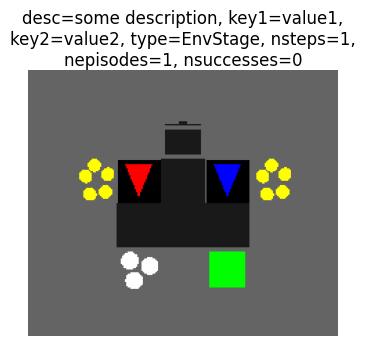

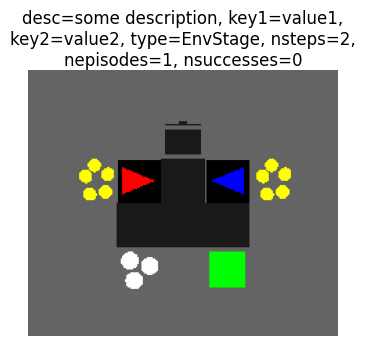

In [15]:
import matplotlib.pyplot as plt


def dict_to_string(data):
  # Convert each key-value pair to "key=value" format
  pairs = [f"{key}={value}" for key, value in data.items()]

  # Join all pairs with ", " separator
  return ", ".join(pairs)


# let's just print out the first few time-step to see what they look like
keys = set()
nidx = 2
# nidx = len(data_dicts)
for idx in range(nidx):
  datum = data_dicts[idx]
  # get the information describing block x stage pairs. you can edit this function if you want
  title = dict_to_string(datum["metadata"])
  timestep = datum["data"]["timestep"]
  timestep = serialization.from_bytes(example_timestep, timestep)
  image = environment.render_fn(timestep)

  fig, ax = plt.subplots(1, 1, figsize=(4, 4))
  ax.imshow(image)
  ax.axis("off")
  ax.set_title(title, wrap=True)
  plt.show()